###Load Data


In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import codecs
import json
import csv

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [11]:
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html
# Convert a JSON string to pandas object

X = pd.read_json('./pizza_request_dataset.json')
print ("type(X)", type(X))
print

# set random seed
np.random.seed(0)

# randomly assign 70% to train_data, and 30% to dev_data
msk = np.random.rand(len(X)) <= 0.7
train_data = X[msk]
dev_data = X[~msk]

# create output dataframe Y of train_labels
train_labels = train_data[["requester_received_pizza"]]

# delete train_labels from input dataframe of train_data
del train_data["requester_received_pizza"]

# create output dataframe of dev_labels
dev_labels = dev_data[["requester_received_pizza"]]

# delete dev_labels from input dataframe of dev_data
del dev_data["requester_received_pizza"]

# print (labels, shapes, and feature names
print ("train_labels" )
print ("----------")
print (list(train_labels))
print (train_labels.shape), "/n"
print ("train_data" )
print ("----------")
print (list(train_data))
print (train_data.shape), "/n"


print ("dev_labels") 
print ("----------")
print (list(dev_labels))
print (dev_labels.shape), "/n"

print ("dev_data")
print ("----------")
print (list(dev_data))
print (dev_data.shape), "/n"

# print (percent of train_data and dev_data whose posts led to receipt of pizza
print ("train labels")
print ("----------")
print (np.mean(train_labels)), "/n"
print ("dev labels")
print ("----------")
print (np.mean(dev_labels))

type(X) <class 'pandas.core.frame.DataFrame'>
train_labels
----------
['requester_received_pizza']
(3975, 1)
train_data
----------
['giver_username_if_known', 'in_test_set', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_title', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_request', 'requester_number_of_posts_at_retrieval', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_on_raop_at_retrieval', 'requester_number_of_subre

##Prepare original and balanced training and dev data

In [63]:
train_text=train_data['request_text'].as_matrix()
train_title=train_data['request_title'].as_matrix()
train_all = train_text+train_title

dev_text=dev_data['request_text'].as_matrix()
dev_title=dev_data['request_title'].as_matrix()
dev_all = dev_text+dev_title

# train_all=train_all.reshape(3975,1)
# dev_all=dev_all.reshape(len(dev_all),1)

In [65]:
print(train_all.shape)
print(dev_all.shape)

(3975,)
(1696,)


In [74]:
train_no_pizza=train_all[np.ravel(train_labels)==False] 
train_pizza=train_all[np.ravel(train_labels)==True] 
train_no_pizza_labels=train_labels[np.ravel(train_labels)==False] 
train_pizza_labels=train_labels[np.ravel(train_labels)==True] 

train_all_balance=np.concatenate((train_no_pizza, train_pizza,train_pizza,train_pizza), axis=0)
train_labels_balance =np.concatenate((train_no_pizza_labels, train_pizza_labels,train_pizza_labels,train_pizza_labels), axis=0)

# train_all_balance=train_all_balance.reshape(len(train_all_balance),1)

####helper method

In [66]:
#Roc curve:
from sklearn.metrics import roc_curve, auc

def model_output(pred_probas, F_Score, preds):

    print ("Logistic regression on numeric data: F-Score = %0.4f: "%(F_Score) ) #Sum up Squared Weights
    accuracy = np.where(preds==np.ravel(dev_labels), 1, 0).sum() / float(len(dev_labels))
    print ("Accuracy = %0.4f" % (accuracy))
    print ('accuracy_score: %f' %metrics.precision_score(dev_labels, preds))
    print ('recall_score: %f' %metrics.recall_score(dev_labels, preds))
    print ("roc_auc_score:", metrics.roc_auc_score(dev_labels, preds))

#Create ROC Curve

    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right')
    
    plt.show()

###Test the base model with imbalanced and balanced dataset

f1_score: 0.301158
precision_score: 0.346154
recall_score: 0.266515
accuracy_score: 0.679835
Logistic regression on numeric data: F-Score = 0.3012: 
Accuracy = 0.6798
accuracy_score: 0.346154
recall_score: 0.266515
roc_auc_score: 0.545349686403


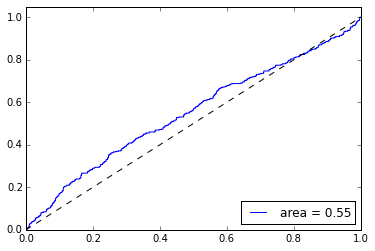

In [68]:
def empty_preprocessor(s):
    return s


vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)


model_LG = LogisticRegression(penalty ='l2',C=12)
model_LG.fit(word_matrix_process, np.ravel(train_labels))

print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process),average='binary'))
print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process)))
print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process)))
print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process)))

preds = model_LG.predict(dev_matrix_process)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG.predict_proba(dev_matrix_process)

#Call to display outputs
model_output(pred_probas, F_Score, preds)


f1_score: 0.314319
precision_score: 0.321429
recall_score: 0.307517
accuracy_score: 0.652712
Logistic regression on numeric data: F-Score = 0.3143: 
Accuracy = 0.6527
accuracy_score: 0.321429
recall_score: 0.307517
roc_auc_score: 0.54039338701


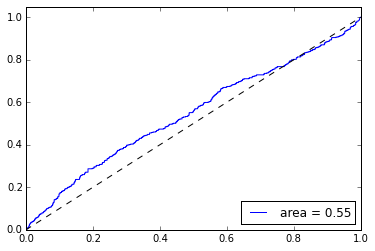

In [141]:
def empty_preprocessor(s):
    return s


vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
dev_matrix_process = vectorizer_process.transform(dev_all)


model_LG = LogisticRegression(penalty ='l2',C=12)
model_LG.fit(word_matrix_process, np.ravel(train_labels_balance))

print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process),average='binary'))
print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process)))
print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process)))
print('accuracy_score: %f' %metrics.accuracy_score(dev_labels,model_LG.predict(dev_matrix_process)))

preds = model_LG.predict(dev_matrix_process)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG.predict_proba(dev_matrix_process)

#Call to display outputs
model_output(pred_probas, F_Score, preds)

###narrative

In [137]:
desire = re.compile(r'(friend|party|birthday|boyfriend|girlfriend|date|drinks|drunk|wasted|invite|invited|celebrate|celebrating|game|games|movie|beer|crave|craving)', re.IGNORECASE)
family = re.compile(r'(husband|wife|family|parent|parents|mother|father|mom|mum|son|dad|daughter)', re.IGNORECASE)
job = re.compile(r'(job|unemployment|employment|hire|hired|fired|interview|work|paycheck)', re.IGNORECASE)
money = re.compile(r'(money|bill|bills|rent|bank|account|paycheck|due|broke|bills|deposit|cash|dollar|dollars|bucks|paid|payed|buy|check|spent|financial|poor|loan|\
credit|budget|day|now|time|week|until|last|month|tonight|today|next|night|when|tomorrow|first|after|while|before|long|hour|Friday|ago|still|due|past|soon|current|years|never|till|yesterday|morning|evening)', re.IGNORECASE)
student = re.compile(r'(college|student|university|finals|study|studying|class|semester|school|roommate|project|tuition|dorm)', re.IGNORECASE)




In [166]:
def myfunc(a,b):
    return len(b.findall(a))/float(len(a))



In [185]:
narrative_all=np.ndarray(shape=(len(train_all_balance),5),dtype=int)
narrative_all_dev=np.ndarray(shape=(len(dev_all),5),dtype=int)

for index,i in enumerate([desire,family,job,money,student]):
    
    vfunc = np.vectorize(myfunc)
    narrative=vfunc(train_all_balance,i)
    narrative_dev=vfunc(dev_all,i)
    med=np.median(narrative)
    narrative_all[:,index]=np.where(narrative>med,1,0)
    narrative_all_dev[:,index]=np.where(narrative_dev>med,1,0)
    


In [242]:


# np.hstack((word_matrix_process, narrative_all))
# word_matrix_process+narrative_all
a=np.concatenate((word_matrix_process.toarray(), narrative_all), axis=1)
b=np.concatenate((dev_matrix_process.toarray(), narrative_all_dev), axis=1)

In [203]:
print(word_matrix_process.shape) 
print(dev_matrix_process.shape) 
print(a.shape) 
print(b.shape) 

(5891, 16083)
(1696, 16083)
(5891, 16088)
(1696, 16088)


Logistic regression on numeric data: F-Score = 0.3302: 
Accuracy = 0.6627
accuracy_score: 0.339759
recall_score: 0.321185
roc_auc_score: 0.55160259721


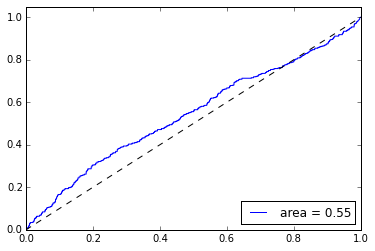

In [243]:
def empty_preprocessor(s):
    return s


vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
dev_matrix_process = vectorizer_process.transform(dev_all)

a=np.concatenate((word_matrix_process.toarray(), narrative_all), axis=1)
b=np.concatenate((dev_matrix_process.toarray(), narrative_all_dev), axis=1)

model_LG = LogisticRegression(penalty ='l2',C=13)
model_LG.fit(a, np.ravel(train_labels_balance))

preds = model_LG.predict(b)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG.predict_proba(b)

#Call to display outputs
model_output(pred_probas, F_Score, preds)

Logistic regression on numeric data: F-Score = 0.3435: 
Accuracy = 0.6686
accuracy_score: 0.352518
recall_score: 0.334852
roc_auc_score: 0.56002740009


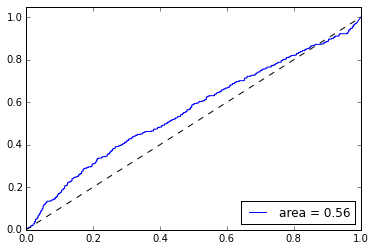

In [245]:
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = empty_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all_balance)
dev_matrix_process = vectorizer_process.transform(dev_all)

a=np.concatenate((word_matrix_process.toarray(), narrative_all), axis=1)
b=np.concatenate((dev_matrix_process.toarray(), narrative_all_dev), axis=1)

model_LG_L1 = LogisticRegression(penalty ='l1',C=400)#C from the above test
model_LG_L1.fit(a, np.ravel(train_labels_balance))

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=13)#C from the above test
model_LG.fit(a[:,index], np.ravel(train_labels_balance))

preds = model_LG.predict(b[:,index])
F_Score = metrics.f1_score(np.ravel(dev_labels), preds, average='binary')
pred_probas = model_LG.predict_proba(b[:,index])

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)